In [1]:
from canonical_model_jax import *

In [2]:
N, n, M, P = 100, 2, 30, 1000
os = OlfactorySensing(N=N, n=n, M=M, P=P, sigma_c=2.44)
key = jax.random.PRNGKey(0)
os.cs = os.draw_cs(key=key) 
W_init = 1 / jnp.sqrt(os.N) * jax.random.gamma(key, a=1, shape=(M, N))
os.W = W_init 

In [7]:
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    return jnp.log(x / (1 - x))

rho_vectorized = jax.vmap(lambda x: compute_rho(x, tol=1e-10), in_axes=0)

In [26]:
def run_sigma_sweep(sigmas): 
    N, n, M, P = 100, 2, 30, 1000
    key = jax.random.PRNGKey(0)
    W_init = 1 / jnp.sqrt(N) * jax.random.gamma(key, a=1, shape=(M, N))
    gamma = 1
    final_rhos = []
    for sigma_c in sigmas: 
        os = OlfactorySensing(N=N, n=n, M=M, P=P, sigma_c=sigma_c)
        os.W = W_init
        os.cs = os.draw_cs(key=key)     
        Ws, ents, losses = natural_gradient_dual_space(20, W_init, os.cs, key, lambda * args: - os.log_det_sigma(*args), 1, os, phi, psi)
        rhos = rho_vectorized(Ws)
        final_rhos.append(rhos[-1]) 
        fig = plot_trajectory(Ws, ents, losses, rhos, sigma_c=sigma_c, gamma=gamma)
        filename = f"sigma_sweep/sigma_{sigma_c:.2g}_gamma_{gamma:.2g}" 
        fig.savefig(filename + '.png')
        jnp.save(filename + '.npy', Ws) 
    return sigmas, final_rhos 

In [27]:
sigmas = jnp.linspace(2, 3, 2) 

Step 0, Loss: 58.79118347167969
Step 2, Loss: 52.97542190551758
Step 4, Loss: 49.06556701660156
Step 6, Loss: 46.98114013671875
Step 8, Loss: 46.40120315551758
Step 10, Loss: 45.02111053466797
Step 12, Loss: 44.91780471801758
Step 14, Loss: 44.0014533996582
Step 16, Loss: 43.78428268432617
Step 18, Loss: 42.891082763671875
Step 0, Loss: 57.99905776977539
Step 2, Loss: 49.685455322265625
Step 4, Loss: 45.28457260131836
Step 6, Loss: 43.0777473449707
Step 8, Loss: 42.414886474609375
Step 10, Loss: 41.151432037353516
Step 12, Loss: 41.07940673828125
Step 14, Loss: 40.401363372802734
Step 16, Loss: 40.33196258544922
Step 18, Loss: 39.413185119628906


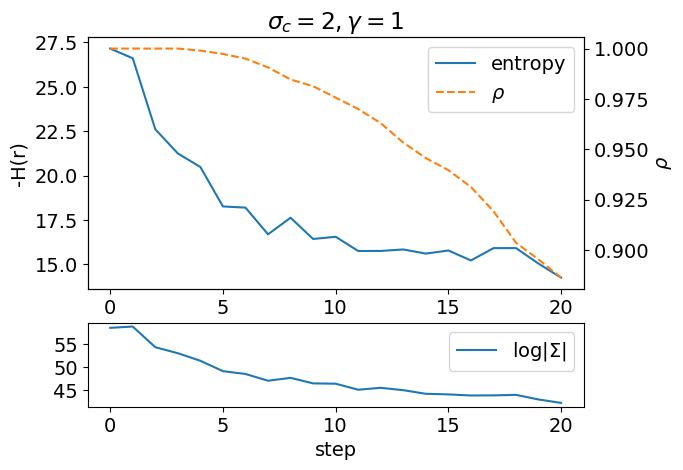

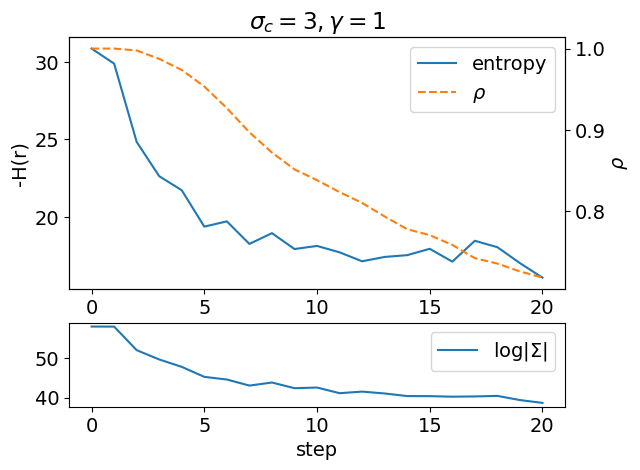

In [28]:
Ws = run_sigma_sweep(sigmas) 